# [作業目標]
- 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
%matplotlib inline

# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [5]:
# 根據年齡分成不同組別 (年齡區間 - 還款與否)
age_data = app_train[['TARGET', 'DAYS_BIRTH']] # subset
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365 # day-age to year-age

#自 20 到 70 歲，切 11 個點 (得到 10 組)
bin_cut =  range(20, 75, 5)
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = bin_cut) 

# 顯示不同組的數量
print(age_data['YEARS_BINNED'].value_counts())
age_data.head()

(35, 40]    42868
(40, 45]    41406
(30, 35]    39440
(45, 50]    35135
(50, 55]    34942
(55, 60]    33120
(25, 30]    32862
(60, 65]    27476
(20, 25]    12159
(65, 70]     8103
Name: YEARS_BINNED, dtype: int64


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25, 30]"
1,0,16765,45.931507,"(45, 50]"
2,0,19046,52.180822,"(50, 55]"
3,0,19005,52.068493,"(50, 55]"
4,0,19932,54.608219,"(50, 55]"


[(20, 25], (25, 30], (30, 35], (35, 40], (40, 45], (45, 50], (50, 55], (55, 60], (60, 65], (65, 70]]
Categories (10, interval[int64]): [(20, 25] < (25, 30] < (30, 35] < (35, 40] ... (50, 55] < (55, 60] < (60, 65] < (65, 70]]


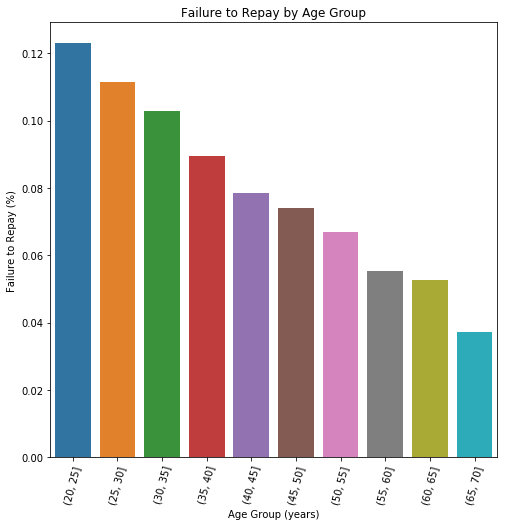

In [6]:
# 繪圖前先排序 / 分組
year_group_sorted = age_data['YEARS_BINNED'].unique().sort_values()
print(year_group_sorted)

# 計算每個年齡區間的 Target、DAYS_BIRTH與 YEARS_BIRTH 的平均值
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot
px = year_group_sorted
py = age_groups['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');